In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import robustness_metrics as rm
import sklearn
# import tensorflow as tf

import random

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized, get_scale_probs, anytime_caching
from utils_uncertainty import  temper_probs
from utils_conformal import conformalize_anytime_nn, conformalize_anytime_nn_raps

import seaborn as sns
import scipy

from matplotlib.gridspec import GridSpec
# import Line2D
from matplotlib.lines import Line2D

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


IMTA and DViT results below are copied from the following repos:
- IMTA: https://github.com/metodj/IMTA/tree/guarantees
- DViT: https://github.com/metodj/Dynamic-Vision-Transformer/tree/guarantees

In [4]:
import matplotlib 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Figure 1

In [3]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [4]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [5]:
# random.seed(0)

# for _ in range(5):
#     samples = random.sample(range(10000), 10)
#     print(samples)
#     for i in samples:
#         # probs_i = probs[:, i, preds[L - 1][i]].cpu()
#         probs_i = probs[:, i, targets[i]].cpu()
#         plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.show()

In [6]:
# # # ground-truth probs
# for i in [1528, 6534, 18, 8086, 5458, 3996, 5328, 1031, 3130, 9298]:
#     probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

In [7]:
# # modal probs
# for i in [6311, 6890, 663, 4242, 8376, 7961, 6634, 4969, 7808, 5866]:
#     probs_i = probs[:, i, preds[L - 1][i]].cpu()
#     # probs_i = probs[:, i, targets[i]].cpu()
#     plt.plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}')
#     plt.title(f'{i}')
#     plt.show()

{0.01: 67.38, 0.1: 49.78, 0.2: 41.72, 0.5: 23.150000000000002}


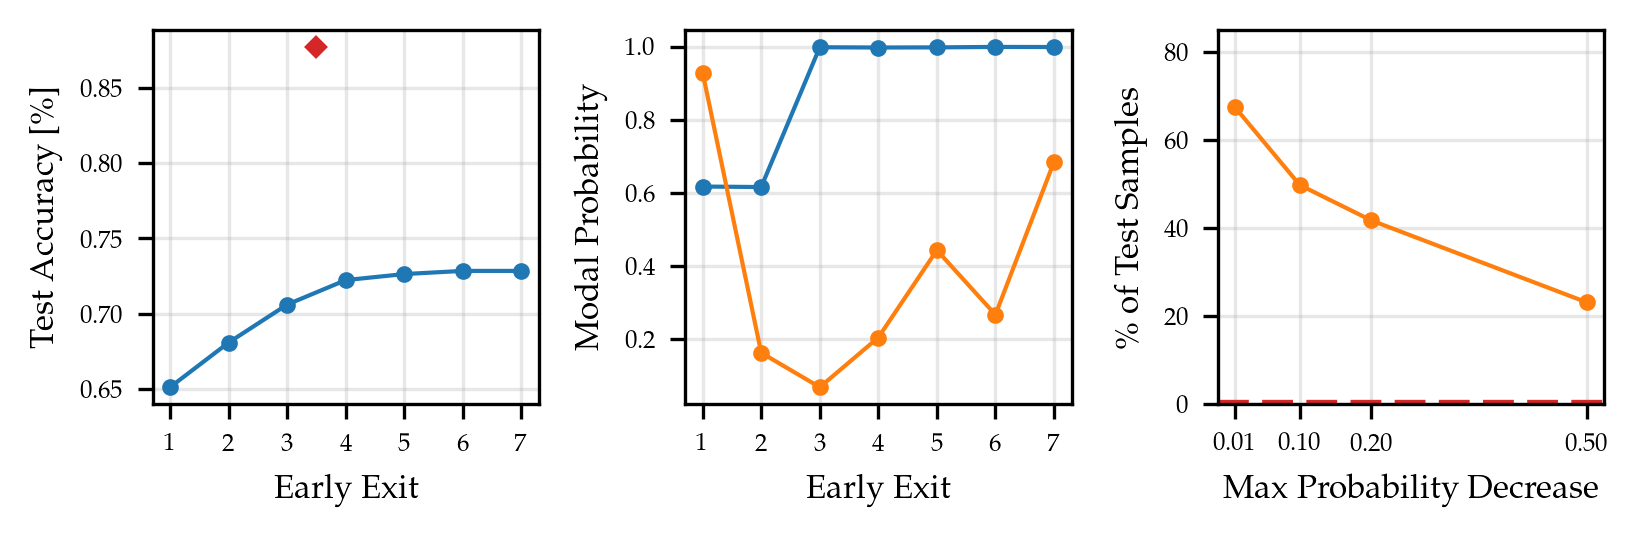

In [8]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width/3))
early_exits = [i + 1 for i in range(L)]

ax[0].plot(early_exits, acc, label='NN', marker='o')
ax[0].plot([3.5], [0.877], marker='D', color='tab:red')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy [\%]')
ax[0].set_xticks(early_exits)

ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i in [6311, 8376]:
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)

THRESHOLDS = [-0.01, -0.1, -0.2, -0.5]
ax[2].set_xlabel('Max Probability Decrease')
ax[2].set_ylabel('\% of Test Samples')
if PLOT_TYPE == 'Modal Probability':
    probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)
elif PLOT_TYPE == 'Ground-Truth Probability':
    probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)
print(probs_decrase)
ax[2].plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax[2].set_xticks(list(probs_decrase.keys()))
# ax[2].tick_params(labelsize=11, axis='x')
ax[2].set_ylim([0., 85.])
# ax[2].set_ylabel('\% of Test Samples')
ax[2].axhline(y=0, color="tab:red", linewidth=2, linestyle='--')

plt.tight_layout()
# plt.savefig(f'figures/figure_1_{PLOT_TYPE}.pdf', dpi=1200, bbox_inches='tight')
plt.show()

TODO: add plot for maximum-softmax-probability decreases

/tmp/ipykernel_1971652/2958883410.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


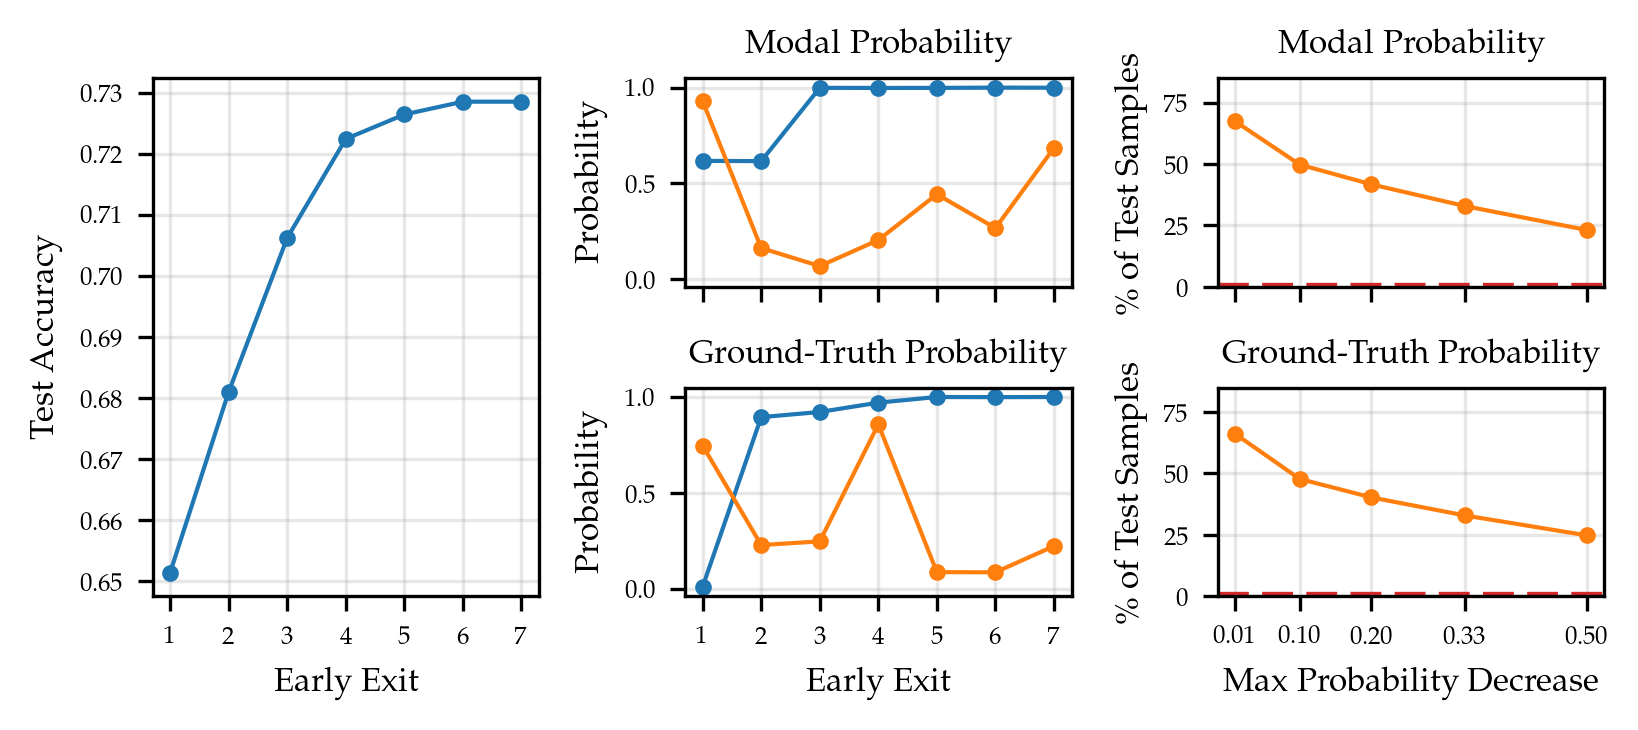

In [9]:
early_exits = [i + 1 for i in range(L)]


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(constrained_layout=True, figsize=(text_width, text_width*0.45))

gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[0, 2])
ax5 = fig.add_subplot(gs[1, 2])

# fig.suptitle("GridSpec")
# format_axes(fig)

ax1.plot(early_exits, acc, label='NN', marker='o')
ax1.set_xlabel('Early Exit')
ax1.set_ylabel('Test Accuracy')
# ax1.plot([3.5], [0.873], marker='o', markersize=6, color='tab:red')
# ax1.axhline(y=0.873, color="tab:red", linewidth=1, linestyle='--')
ax1.set_xticks(early_exits)

# ax2.set_xlabel('Early Exit')
ax2.set_ylabel('Probability')
ax2.set_title('Modal Probability')
ax2.set_xticks(early_exits)
ax2.set_xticklabels([])
for i in [6311, 8376]:
    probs_i = probs[:, i, preds[L - 1][i]].cpu()
    ax2.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


ax3.set_xlabel('Early Exit')
ax3.set_ylabel('Probability')
ax3.set_title('Ground-Truth Probability')
ax3.set_xticks(early_exits)
for i in [4969, 6534]:
    probs_i = probs[:, i, targets[i]].cpu()
    ax3.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')

ax3.sharey(ax2)


THRESHOLDS = [-0.01, -0.1, -0.2, -0.33, -0.5]
# ax4.set_xlabel('Max Probability Decrease')
# ax4.set_ylabel('\% of Test Samples')
probs_decrase = modal_probs_decreasing(preds, probs, L, N=N, diffs_type="all", thresholds=THRESHOLDS)

ax4.plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])

ax4.set_ylim([0., 85.])
ax4.set_ylabel('\% of Test Samples')
ax4.axhline(y=0, color="tab:red", lw=2, linestyle='--')
ax4.set_title('Modal Probability')
ax4.set_xticks(list(probs_decrase.keys()))
ax4.set_xticklabels([])


ax5.set_xlabel('Max Probability Decrease')
ax5.set_ylabel('\% of Test Samples')
probs_decrase = modal_probs_decreasing(targets, probs, layer=None, N=N, diffs_type="all", thresholds=THRESHOLDS)

ax5.plot(probs_decrase.keys(), probs_decrase.values(), marker='o',  color='tab:orange')
# ax[2].set_xticks(list(probs_decrase.keys()), [int(i * 100) for i in probs_decrase.keys()])
ax5.set_xticks(list(probs_decrase.keys()))
ax5.set_ylim([0., 85.])
# ax[2].set_ylabel('\% of Test Samples')
ax5.axhline(y=0, color="tab:red", linewidth=2, linestyle='--')
ax5.set_title('Ground-Truth Probability')

ax5.sharey(ax4)

# elif PLOT_TYPE == 'Ground-Truth Probability':
#     
# print(probs_decrase)

plt.tight_layout()
plt.savefig(f'figures/figure_1_alt.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure 2

In [63]:
# UPDATED RESULTS: April 2023
CIFAR_10_DICT = {"MSDNet": [0.833, 0.8575, 0.8733, 0.8768, 0.8779, 0.8687, 0.8692], 
                  "MSDNet-PA": [0.833, 0.8627, 0.8803, 0.8857, 0.8881, 0.884, 0.8838], 
                  "MSDNet-CA": [0.833, 0.8594, 0.8756, 0.8815, 0.8845, 0.8823, 0.8812],
                  "IMTA": [0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259], 
                  "IMTA-PA": [0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252],
                  "IMTA-CA": [0.89, 0.901, 0.9098, 0.9147, 0.9182, 0.9191, 0.9199],
                  "DViT": [0.9636, 0.9744, 0.9809],
                  "DViT-PA": [0.9636, 0.9742, 0.9786],
                  "DViT-CA": [0.9636, 0.9725, 0.9773],
                }

CIFAR_100_DICT = {"MSDNet": [0.6532, 0.683, 0.7078, 0.7231, 0.7254, 0.7281, 0.7274], 
                  "MSDNet-PA": [0.6532, 0.7017, 0.7347, 0.7488, 0.7541, 0.7577, 0.7571], 
                  "MSDNet-CA": [0.6532, 0.6953, 0.7265, 0.7391, 0.7451, 0.748, 0.7516],
                  "IMTA": [0.6222, 0.6685, 0.6966, 0.7143, 0.7189, 0.7216, 0.7226], 
                  "IMTA-PA": [0.6222, 0.6665, 0.6958, 0.7148, 0.7255, 0.7316, 0.7331],
                  "IMTA-CA": [0.6222, 0.6606, 0.6867, 0.707, 0.7168, 0.7218, 0.7234],
                  "DViT": [0.8374, 0.8579, 0.8716],
                  "DViT-PA": [0.8374, 0.8642, 0.8756],
                  "DViT-CA": [0.8374, 0.8607, 0.8738],
                }


IMAGE_NET_DICT = {"MSDNet": [0.5663, 0.6514, 0.6842, 0.6977, 0.7134], 
                  "MSDNet-PA": [0.5663, 0.6508, 0.6867, 0.7022, 0.7138], 
                  "MSDNet-CA": [0.5663, 0.6427, 0.676, 0.6912, 0.7044],
                  "IMTA": [0.5716, 0.6585, 0.6998, 0.7186, 0.7275],
                  "IMTA-PA": [0.5716, 0.6541, 0.6931, 0.7142, 0.7304],
                  "IMTA-CA": [0.5716, 0.6467, 0.6868, 0.7078, 0.7219],
                  "DViT": [0.6906, 0.7566, 0.7999],
                  "DViT-PA": [0.6906, 0.7529, 0.7904],
                  "DViT-CA": [0.6906, 0.7496, 0.7889],
                }


In [13]:
COLOR_DICT = {"MSDNet": "tab:blue", "IMTA": "tab:green", "DViT": "tab:orange"}

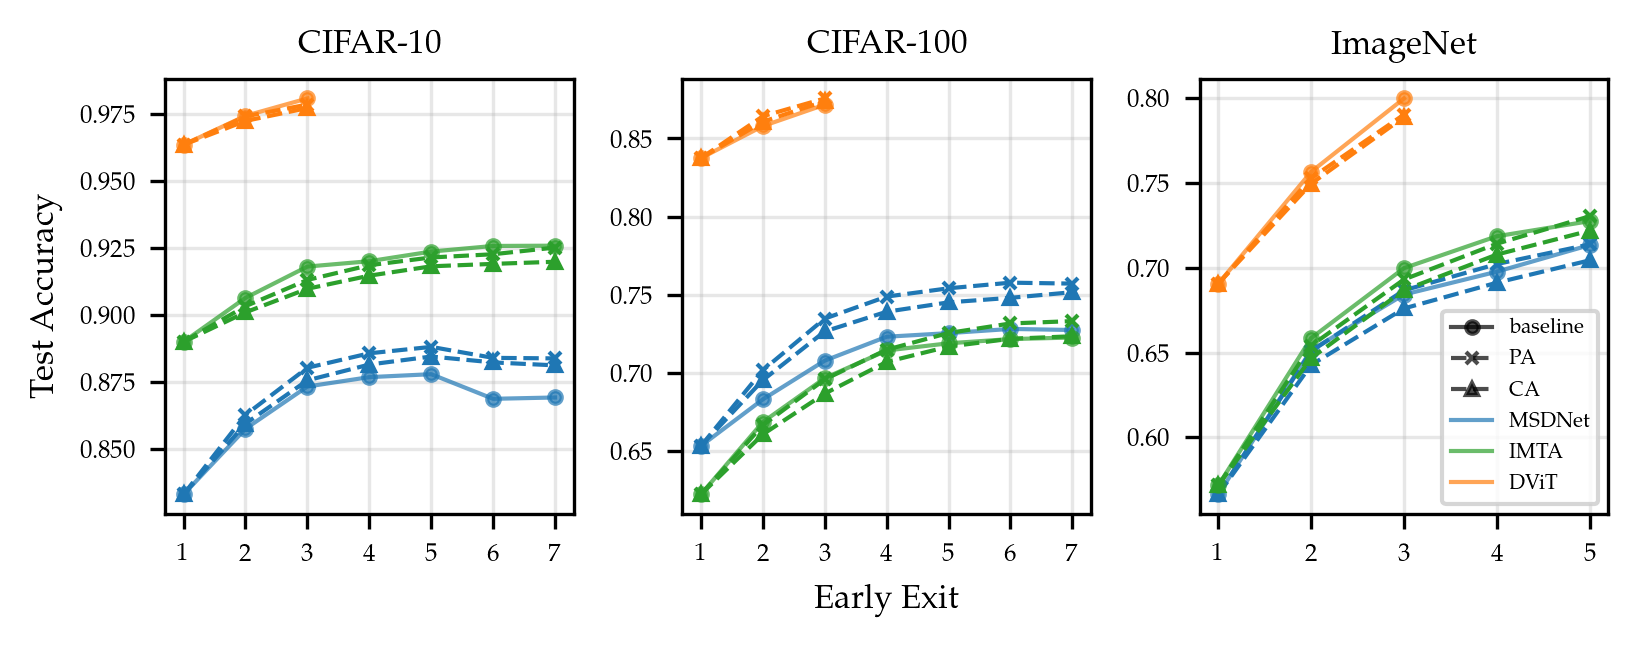

In [23]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 3, figsize=(text_width, 0.4*text_width))

ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet"]) + 1)), CIFAR_10_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-PA"]) + 1)), CIFAR_10_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-CA"]) + 1)), CIFAR_10_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA"]) + 1)), CIFAR_10_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-PA"]) + 1)), CIFAR_10_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-CA"]) + 1)), CIFAR_10_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT"]) + 1)), CIFAR_10_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-PA"]) + 1)), CIFAR_10_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-CA"]) + 1)), CIFAR_10_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
# ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('CIFAR-10')
ax[0].set_xticks([x for x in range(1, 8)])
# ax[0].legend()

ax[1].plot(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), CIFAR_100_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[1].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-PA"]) + 1)), CIFAR_100_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-CA"]) + 1)), CIFAR_100_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), CIFAR_100_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[1].plot(list(range(1, len(CIFAR_100_DICT["IMTA-PA"]) + 1)), CIFAR_100_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["IMTA-CA"]) + 1)), CIFAR_100_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["DViT"]) + 1)), CIFAR_100_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[1].plot(list(range(1, len(CIFAR_100_DICT["DViT-PA"]) + 1)), CIFAR_100_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[1].plot(list(range(1, len(CIFAR_100_DICT["DViT-CA"]) + 1)), CIFAR_100_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel('Test Accuracy')
ax[1].set_title('CIFAR-100')
ax[1].set_xticks([x for x in range(1, 8)])
# ax[1].legend()



ax[2].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), IMAGE_NET_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-PA"]) + 1)), IMAGE_NET_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-CA"]) + 1)), IMAGE_NET_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["IMTA"]) + 1)), IMAGE_NET_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-PA"]) + 1)), IMAGE_NET_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-CA"]) + 1)), IMAGE_NET_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["DViT"]) + 1)), IMAGE_NET_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["DViT-PA"]) + 1)), IMAGE_NET_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[2].plot(list(range(1, len(IMAGE_NET_DICT["DViT-CA"]) + 1)), IMAGE_NET_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
# ax[2].set_xlabel('Early Exit')
# ax[2].set_ylabel('Test Accuracy')
ax[2].set_title('ImageNet')
# ax[2].legend(fontsize=11)
ax[2].set_xticks([x for x in range(1, 6)])
# ax[2].legend()

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[2].legend(lines, labels, loc='lower right', fontsize=5)


plt.tight_layout()
plt.savefig(f'figures/figure_2_caching_baseline.pdf', bbox_inches='tight')
plt.show()

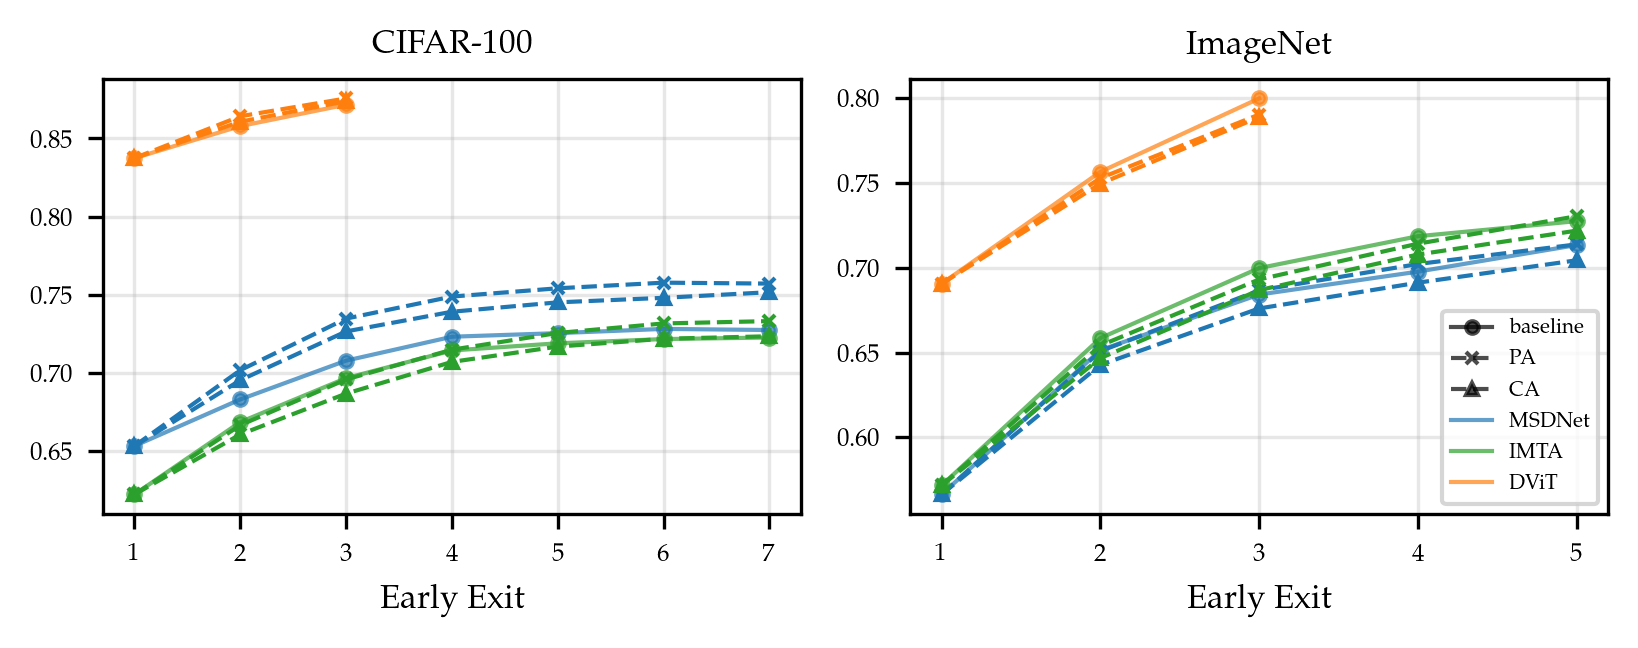

In [64]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 2, figsize=(text_width, 0.4*text_width))


# ax[0].legend()

ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet"]) + 1)), CIFAR_100_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-PA"]) + 1)), CIFAR_100_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["MSDNet-CA"]) + 1)), CIFAR_100_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA"]) + 1)), CIFAR_100_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA-PA"]) + 1)), CIFAR_100_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["IMTA-CA"]) + 1)), CIFAR_100_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["DViT"]) + 1)), CIFAR_100_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_100_DICT["DViT-PA"]) + 1)), CIFAR_100_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_100_DICT["DViT-CA"]) + 1)), CIFAR_100_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].set_xlabel('Early Exit')
# ax[1].set_ylabel('Test Accuracy')
ax[0].set_title('CIFAR-100')
ax[0].set_xticks([x for x in range(1, 8)])
# ax[1].legend()



ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet"]) + 1)), IMAGE_NET_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-PA"]) + 1)), IMAGE_NET_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["MSDNet-CA"]) + 1)), IMAGE_NET_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["IMTA"]) + 1)), IMAGE_NET_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-PA"]) + 1)), IMAGE_NET_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["IMTA-CA"]) + 1)), IMAGE_NET_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT"]) + 1)), IMAGE_NET_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT-PA"]) + 1)), IMAGE_NET_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[1].plot(list(range(1, len(IMAGE_NET_DICT["DViT-CA"]) + 1)), IMAGE_NET_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
# ax[2].set_xlabel('Early Exit')
# ax[2].set_ylabel('Test Accuracy')
ax[1].set_title('ImageNet')
ax[1].set_xlabel('Early Exit')
# ax[2].legend(fontsize=11)
ax[1].set_xticks([x for x in range(1, 6)])
# ax[2].legend()

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[1].legend(lines, labels, loc='lower right', fontsize=5)


plt.tight_layout()
plt.savefig(f'figures/figure_2_caching_baseline_no_cifar_10.pdf', bbox_inches='tight')
plt.show()

# Tables 1 & 2

In [14]:
THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

# UPDATED RESULTS: April 2023
CIFAR_10_DICT = {"MSDNet": [70.47, 45.98, 34.5, 28.6, 21.15, 18.16, 14.02, 7.43], 
                  "MSDNet-PA": [5.47, 3.73, 0.98, 0.25, 0.05, 0.03, 0.01, 0.01], 
                  "MSDNet-CA": [4.13, 4.0, 3.57, 3.12, 2.3, 2.05, 1.59, 0.85],
                  "IMTA": [47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0], 
                  "IMTA-PA": [1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [1.08, 1.01, 0.86, 0.69, 0.44, 0.33, 0.2, 0.08],
                  "DViT": [37.6, 4.63, 2.65, 1.83, 1.04, 0.79, 0.54, 0.13],
                  "DViT-PA": [0.43, 0.27, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [0.17, 0.16, 0.13, 0.1, 0.07, 0.05, 0.02, 0.0],
                }

CIFAR_100_DICT = {"MSDNet": [86.76, 67.36, 56.36, 50.38, 41.6, 38.05, 32.95, 23.19], 
                  "MSDNet-PA": [0.36, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  "MSDNet-CA": [12.18, 11.13, 9.56, 8.18, 6.13, 5.36, 4.45, 2.7],
                  "IMTA": [74.75, 53.61, 41.85, 35.13, 25.96, 22.8, 17.69, 9.39], 
                  "IMTA-PA": [0.3, 0.15, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [6.97, 6.22, 5.08, 4.28, 3.04, 2.57, 1.96, 0.95],
                  "DViT": [67.44, 32.98, 20.94, 15.2, 8.62, 6.71, 4.19, 1.29],
                  "DViT-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [0.84, 0.78, 0.61, 0.41, 0.24, 0.18, 0.08, 0.02],
                }


IMAGE_NET_DICT = {"MSDNet": [84.326, 69.972, 51.72, 38.066, 20.518, 14.666, 8.336, 2.024], 
                  "MSDNet-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                  "MSDNet-CA": [5.062, 4.452, 2.918, 1.788, 0.638, 0.402, 0.178, 0.022],
                  "IMTA": [79.162, 61.17, 42.818, 30.452, 15.556, 10.884, 5.71, 1.184],
                  "IMTA-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [4.704, 4.006, 2.592, 1.588, 0.594, 0.31, 0.122, 0.01],
                  "DViT": [55.22, 49.3, 27.944, 13.108, 3.608, 2.014, 0.756, 0.066],
                  "DViT-PA": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [1.51, 1.204, 0.682, 0.342, 0.096, 0.028, 0.006, 0.0],
}


SELECTED_THRESHOLDS = [0.01, 0.1, 0.25]

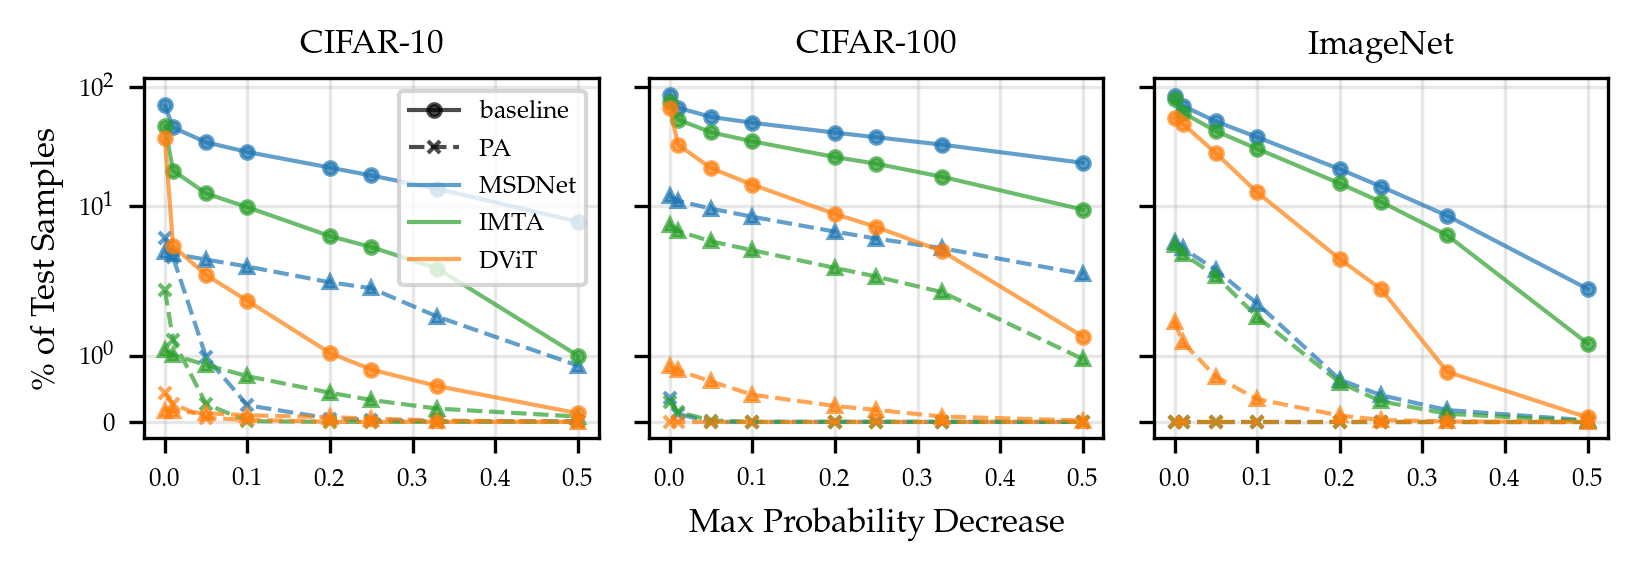

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4.25/12), sharex=True, sharey=True)

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': '--', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': '--',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': '--'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

for name, percentages in CIFAR_10_DICT.items():
    ax[0].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[0].set_xlabel('Max Probability Decrease')
ax[0].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[0].set_yscale('symlog')
ax[0].set_title('CIFAR-10')

for name, percentages in CIFAR_100_DICT.items():
    ax[1].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Probability Decrease')
# ax[1].set_ylabel('\% of Test Samples')
# ax[1].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('CIFAR-100')

for name, percentages in IMAGE_NET_DICT.items():
    ax[2].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[2].set_xlabel('Max Probability Decrease')
# ax[2].set_ylabel('\% of Test Samples')
# ax[2].legend()
# set log scale
ax[2].set_yscale('symlog')
ax[2].set_title('ImageNet')
# ax[2].set_xticks(THRESHOLDS)

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'MSDNet', 'IMTA', 'DViT']
ax[0].legend(lines, labels, loc='upper right')

plt.tight_layout()
# plt.savefig(f'figures/figure_2_5_prob_decrese_caching_baseline.pdf', dpi=1200, bbox_inches='tight')
plt.show()

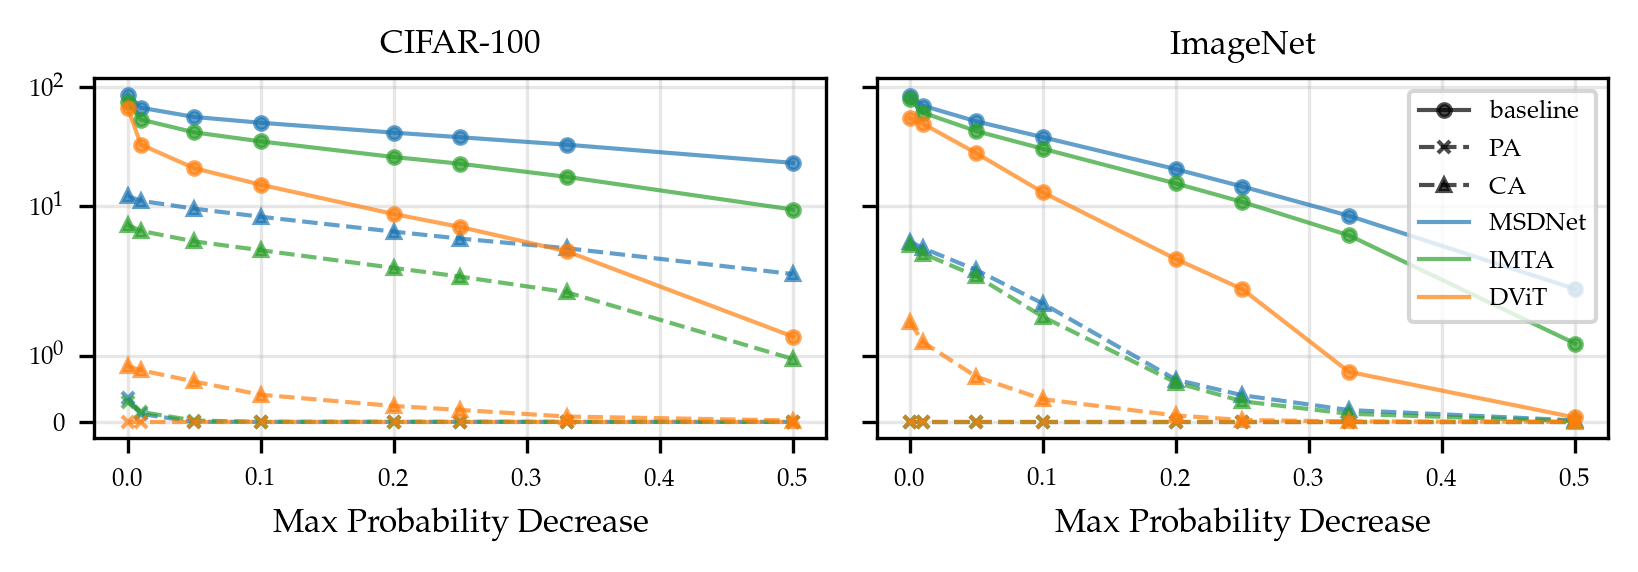

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(text_width, text_width * 4.25/12), sharex=True, sharey=True)

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': '--', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': '--',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': '--'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}


for name, percentages in CIFAR_100_DICT.items():
    ax[0].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[0].set_xlabel('Max Probability Decrease')
# ax[1].set_ylabel('\% of Test Samples')
# ax[1].legend()
# set log scale
ax[0].set_yscale('symlog')
ax[0].set_title('CIFAR-100')

for name, percentages in IMAGE_NET_DICT.items():
    ax[1].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

# ax[2].set_xlabel('Max Probability Decrease')
# ax[2].set_ylabel('\% of Test Samples')
# ax[2].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('ImageNet')
ax[1].set_xlabel('Max Probability Decrease')
# ax[2].set_xticks(THRESHOLDS)

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[1].legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig(f'figures/figure_2_5_prob_decrese_caching_baseline_no_cifar_10.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [15]:
cifar_10_guarantees_df = pd.DataFrame(CIFAR_10_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]
cifar_100_guarantees_df = pd.DataFrame(CIFAR_100_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]
image_net_guarantees_df = pd.DataFrame(IMAGE_NET_DICT, index=THRESHOLDS).T[SELECTED_THRESHOLDS]

In [16]:
cifar_10_guarantees_df

,0.01,0.10,0.25
MSDNet,45.98,28.60,18.16
MSDNet PoE-OVR,3.73,0.25,0.03
IMTA,19.98,9.83,4.55
IMTA PoE-OVR,1.24,0.01,0.00
DViT,4.63,1.83,0.79
DViT PoE-OVR,0.27,0.03,0.00


In [17]:
for row in cifar_10_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
45.98 & 28.6 & 18.16
MSDNet PoE-OVR
3.73 & 0.25 & 0.03
IMTA
19.98 & 9.83 & 4.55
IMTA PoE-OVR
1.24 & 0.01 & 0.0
DViT
4.63 & 1.83 & 0.79
DViT PoE-OVR
0.27 & 0.03 & 0.0


In [18]:
cifar_100_guarantees_df

,0.01,0.10,0.25
MSDNet,67.37,49.78,38.21
MSDNet PoE-OVR,0.12,0.00,0.00
IMTA,53.61,35.13,22.80
IMTA PoE-OVR,0.15,0.00,0.00
DViT,32.98,15.20,6.71
DViT PoE-OVR,0.00,0.00,0.00


In [19]:
for row in cifar_100_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
67.37 & 49.78 & 38.21
MSDNet PoE-OVR
0.12 & 0.0 & 0.0
IMTA
53.61 & 35.13 & 22.8
IMTA PoE-OVR
0.15 & 0.0 & 0.0
DViT
32.98 & 15.2 & 6.71
DViT PoE-OVR
0.0 & 0.0 & 0.0


In [20]:
image_net_guarantees_df

,0.01,0.10,0.25
MSDNet,69.972,38.066,14.666
MSDNet PoE-OVR,0.000,0.000,0.000
IMTA,61.170,30.452,10.884
IMTA PoE-OVR,0.000,0.000,0.000
DViT,51.090,12.104,2.722
DViT PoE-OVR,0.000,0.000,0.000


In [21]:
for row in image_net_guarantees_df.iterrows():
    print(row[0])
    print(' & '.join([str(x) for x in row[1].values]))

MSDNet
69.972 & 38.066 & 14.666
MSDNet PoE-OVR
0.0 & 0.0 & 0.0
IMTA
61.17 & 30.452 & 10.884
IMTA PoE-OVR
0.0 & 0.0 & 0.0
DViT
51.09 & 12.104 & 2.722
DViT PoE-OVR
0.0 & 0.0 & 0.0


# Figure 3

In [36]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [37]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [38]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [40]:
probs_stateful = anytime_caching(probs, N=N, L=L)
preds_stateful = {i: torch.argmax(probs_stateful, dim=2)[i, :] for i in range(L)}
acc_stateful = [(targets == preds_stateful[i]).sum() / len(targets) for i in range(L)]

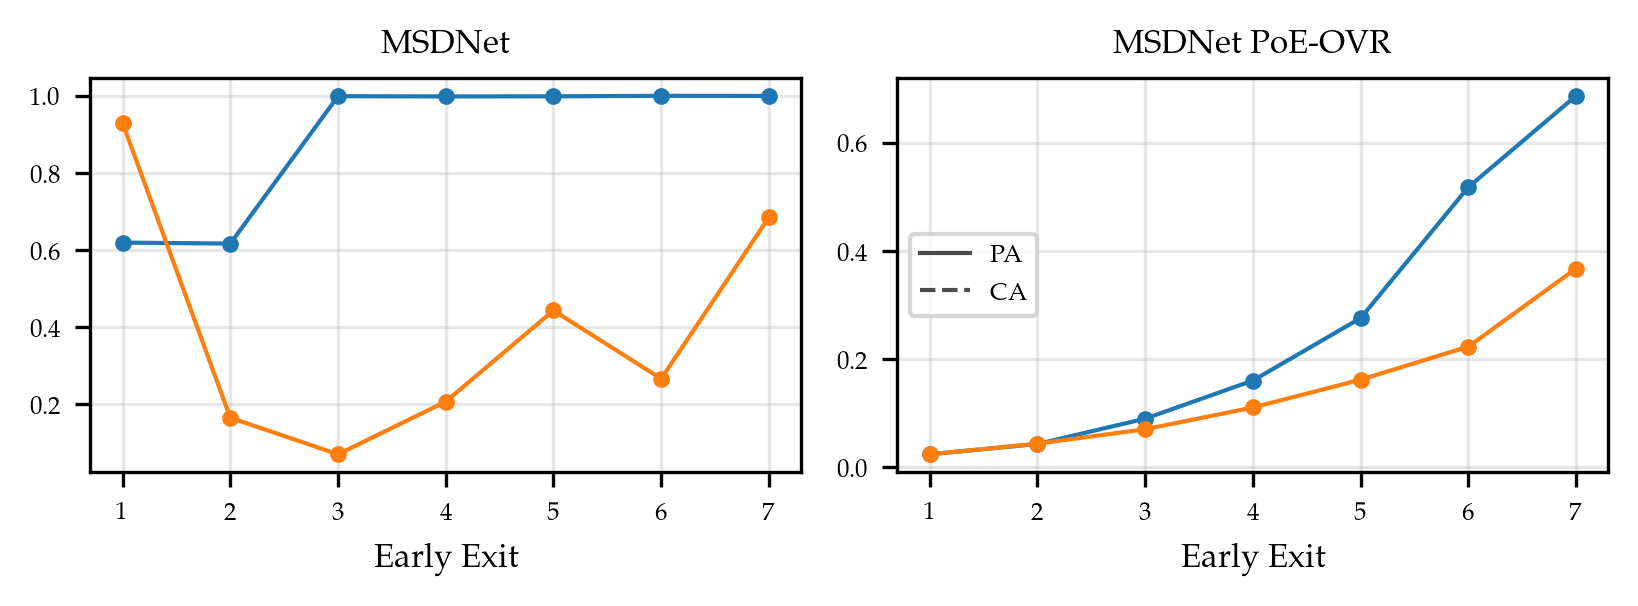

In [54]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'Modal Probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 2, figsize=(text_width, text_width * 3/8))
early_exits = [i + 1 for i in range(L)]

ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[0].set_xticks(early_exits)
ax[0].set_title('MSDNet')


ax[1].set_xlabel('Early Exit')
# ax[1].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'Modal Probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
ax[1].set_xticks(early_exits)
ax[1].set_title('MSDNet PoE-OVR')

plt.tight_layout()
# plt.savefig(f'figures/figure_3_{PLOT_TYPE}.pdf', dpi=1200, bbox_inches='tight')
plt.show()

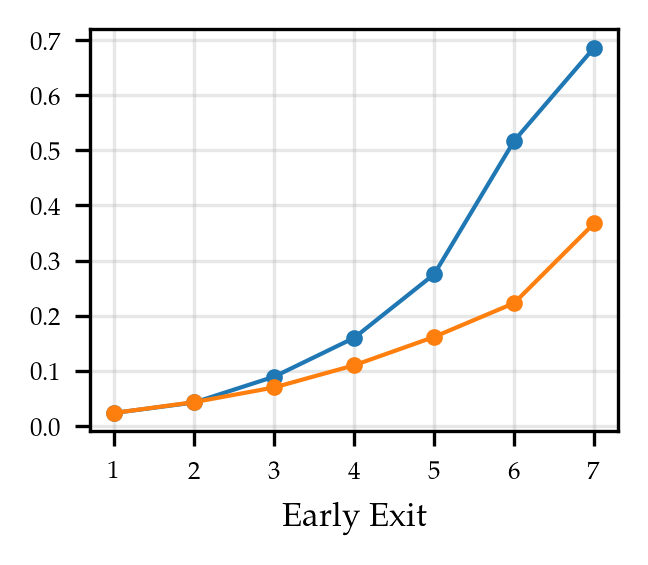

In [26]:
# FONT_SIZE = 12
# plt.rcParams.update({'font.size': FONT_SIZE})

PLOT_TYPE = 'modal_probability'
# PLOT_TYPE = 'Ground-Truth Probability'

fig, ax = plt.subplots(1, 1, figsize=(text_width * 0.4, text_width/2 * 3.5/5))
early_exits = [i + 1 for i in range(L)]

plt.xlabel('Early Exit')
# ax[0].set_ylabel(PLOT_TYPE)
if PLOT_TYPE == 'modal_probability':
    for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
        # probs_i = probs[:, i, preds[L - 1][i]].cpu()
        # plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
        probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
elif PLOT_TYPE == 'Ground-Truth Probability':
    for i in [6311, 6534]:
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
        probs_i = probs[:, i, targets[i]].cpu()
        plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')


plt.tight_layout()
plt.savefig(f'figures/figure_3_{PLOT_TYPE}_half.pdf', dpi=1200, bbox_inches='tight')
plt.show()

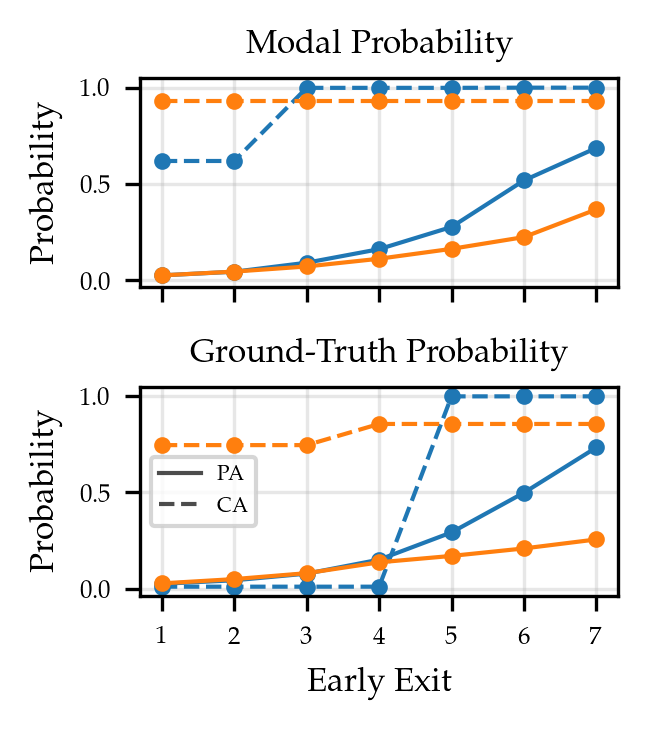

In [60]:
# FONT_SIZE = 12

fig, axs = plt.subplots(2, 1, figsize=(text_width * 0.4, text_width * 0.45), sharey=True, sharex=True)
early_exits = [i + 1 for i in range(L)]


# ax[0].set_ylabel(PLOT_TYPE)

for i, color in zip([6311, 8376], ['tab:blue', 'tab:orange']):
    # probs_i = probs[:, i, preds[L - 1][i]].cpu()
    # plt.plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color)
    probs_i = probs_poe_ovr_break_ties_generalized[:, i, preds_poe_ovr_break_ties_generalized[L - 1][i]].cpu()
    probs_i_caching = probs_stateful[:, i, preds_stateful[L - 1][i]].cpu()
    axs[0].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color, label='PA')
    axs[0].plot(list(range(1, len(probs_i_caching) + 1)), probs_i_caching, marker='o', color=color, linestyle='--', label='CA')


# axs[0].set_xlabel('Early Exit')
axs[0].set_ylabel('Probability')
axs[0].set_title('Modal Probability')
axs[0].set_xticks(early_exits)

for i, color in zip([4969, 6534], ['tab:blue', 'tab:orange']):
    # probs_i = probs[:, i, targets[i]].cpu()
    # axs[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o')
    probs_i = probs_poe_ovr_break_ties_generalized[:, i, targets[i]].cpu()
    probs_i_caching = probs_stateful[:, i, targets[i]].cpu()
    axs[1].plot(list(range(1, len(probs_i) + 1)), probs_i, marker='o', color=color, label='PA')
    axs[1].plot(list(range(1, len(probs_i_caching) + 1)), probs_i_caching, marker='o', linestyle='--', color=color, label='CA')

axs[1].set_xlabel('Early Exit')
axs[1].set_ylabel('Probability')
axs[1].set_title('Ground-Truth Probability')

lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', alpha=0.7),
]
labels = ['PA', 'CA']
axs[1].legend(lines, labels, loc='center left', fontsize=5)

plt.tight_layout()
plt.savefig(f'figures/figure_3_joined_half_caching_baseline.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure 4

In [28]:
MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

L = len(logits)
N = len(targets)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [29]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [30]:
T = 1.
probs_poe_ovr_break_ties_generalized = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties_generalized = {i: torch.argmax(probs_poe_ovr_break_ties_generalized, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties_generalized = [(targets == preds_poe_ovr_break_ties_generalized[i]).sum() / len(targets) for i in range(L)]

In [31]:
scaled_dict = get_scale_probs(['PoE-OVR (tempered)'], [probs_poe_ovr_break_ties_generalized], [2.], targets, C=ARGS.num_classes, L=L)
probs_poe_ovr_break_ties_generalized_tempered = scaled_dict['PoE-OVR (tempered)'][2.0][0]

In [32]:
_probs_poe_ovr_break_ties_generalized_tempered = temper_probs(probs_poe_ovr_break_ties_generalized, .5)
_probs_poe_ovr_break_ties_generalized_tempered_multi = temper_probs(
    probs_poe_ovr_break_ties_generalized,
    np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None]).to(torch.float32)

In [33]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [34]:
random.seed(10)
CALIB_SIZE = 0.2
ALPHA = 0.05
calib_ids = random.sample(range(N), int(CALIB_SIZE * N))
valid_ids = list(set(range(N)) - set(calib_ids))

# sizes_conf_sets,_ = conformalize_anytime_nn(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe,_ = conformalize_anytime_nn(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
# sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn(probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L, conf_type='smx')
sizes_conf_sets,_ = conformalize_anytime_nn_raps(probs.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe,_ = conformalize_anytime_nn_raps(probs_poe.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized, _ = conformalize_anytime_nn_raps(probs_poe_ovr_break_ties_generalized.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)
sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi, _ = conformalize_anytime_nn_raps(_probs_poe_ovr_break_ties_generalized_tempered_multi.cpu().numpy(), targets, calib_ids=calib_ids, valid_ids=valid_ids, C=ARGS.num_classes, L=L)

1 1.0324929980975721
2 1.0195449964975698
3 1.010824835721305
4 1.0076205733814623
5 1.0110751561137006
6 1.016485761184303
7 1.0194407895404107
1 1.032164740179095
2 0.9984557576387849
3 0.9987043405566113
4 0.9989350273192706
5 0.999220756994655
6 0.9990251785680488
7 0.9988836663841492
1 0.28856089396136714
2 0.28148119748446604
3 0.3727318367783411
4 0.48952006730685776
5 0.6395963118389898
6 0.7726161506953443
7 0.8917985669801565
1 0.3224457868267028
2 0.3821150802890932
3 0.549952482104689
4 0.7429939506647315
5 0.883867225571166
6 0.9599821783687809
7 0.9941407841523935
1 0.42596446316605385
2 0.5539300771176714
3 0.7439306900814633
4 0.846494870597701
5 0.9458120559142192
6 0.9769661493359086
7 0.9947689829869519


In [35]:
entropy_baseline = scipy.stats.entropy(probs.numpy(), axis=2)
entropy_poe = scipy.stats.entropy(probs_poe.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized = scipy.stats.entropy(probs_poe_ovr_break_ties_generalized.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered.numpy(), axis=2)
entropy_poe_ovr_break_ties_generalized_tempered_multi = scipy.stats.entropy(_probs_poe_ovr_break_ties_generalized_tempered_multi.numpy(), axis=2)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-04-05 22:47:47.667246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:47:47.668972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20695 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


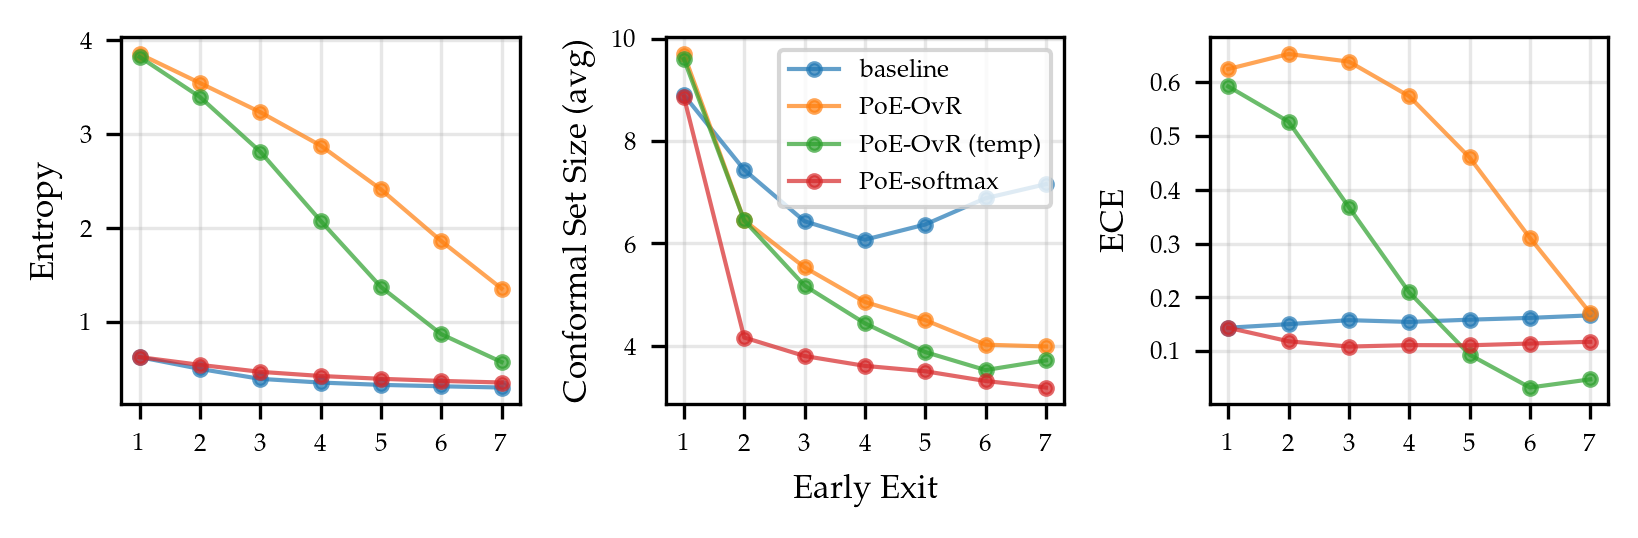

In [36]:
NAMES = [
    'baseline',
    'PoE-OvR',
    # 'MSDNet PoE-OvR (tempered)',
    'PoE-OvR (temp)',
    'PoE-softmax',
]
COLORS = [
    'tab:blue',
    'tab:orange',
    # 'tab:green',
    'tab:green',
    'tab:red',
]
PROBS = [
    probs,
    probs_poe_ovr_break_ties_generalized,
    # _probs_poe_ovr_break_ties_generalized_tempered,
    _probs_poe_ovr_break_ties_generalized_tempered_multi,
    probs_poe,
]

fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width * 4 / 12), sharex=True)

for _entropy, label, color in zip([entropy_baseline, entropy_poe_ovr_break_ties_generalized, entropy_poe_ovr_break_ties_generalized_tempered, entropy_poe, entropy_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[0].plot(list(range(1, L + 1)), _entropy.mean(axis=1), marker='o', label=label, color=color, alpha=0.7)
# ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Entropy')


for _sizes, label, color in zip([sizes_conf_sets, sizes_conf_sets_poe_ovr_break_ties_generalized, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered, sizes_conf_sets_poe, sizes_conf_sets_poe_ovr_break_ties_generalized_tempered_multi], NAMES, COLORS):
    ax[1].plot(list(range(1, L + 1)), _sizes, marker='o', label=label, color=color, alpha=0.7)
ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Conformal Set Size (avg)')
ax[1].set_xticks(list(range(1, L + 1)))


for _probs, label, color in zip(PROBS, NAMES, COLORS):
    eces = []
    eces_rm = []
    for l in range(L):
        # eces.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
        ece = rm.metrics.ExpectedCalibrationError(num_bins=15)
        ece.add_batch(_probs[l, :, :].numpy(), label=targets.numpy())
        eces_rm.append(ece.result()['ece'])
    # ax[2].plot(list(range(1, L + 1)), eces, '-', marker='o', label=label, color=color, alpha=0.5)
    ax[2].plot(list(range(1, L + 1)), eces_rm, '-', marker='o', label=label, color=color, alpha=0.7)
# ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE')

ax[1].legend()



plt.tight_layout()
plt.savefig(f'figures/figure_4_raps.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure Categorical likelihoods

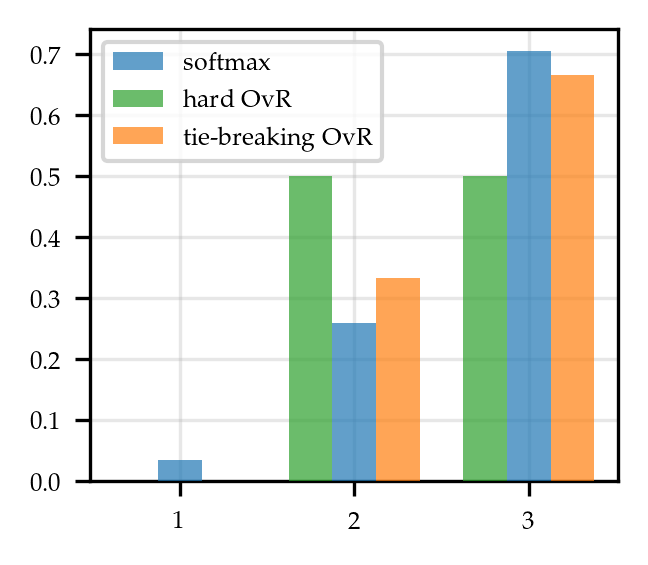

In [37]:
a = torch.tensor([-1., 1., 2.])
b = torch.softmax(a, dim=0).numpy()
c = (torch.sigmoid(a).round() / 2).numpy()
d = torch.tensor([0., 1/3, 2/3])
x = np.arange(1, 4, 1)

fig, ax = plt.subplots(figsize=(text_width * 0.4, text_width/2 * 0.7))
plt.bar(x, b, width=0.25, color='tab:blue', align='center', label='softmax', zorder=5, alpha=0.7)
plt.bar(x-0.25, c, width=0.25, color='tab:green', align='center', label='hard OvR', zorder=5, alpha=0.7)
plt.bar(x+0.25, d, width=0.25, color='tab:orange', align='center', label='tie-breaking OvR', zorder=5, alpha=0.7)
plt.xticks(x, [1, 2, 3])
plt.legend()
plt.grid(alpha=0.3, zorder=-5)
plt.savefig(f'figures/figure_likelihoods.pdf', dpi=1200, bbox_inches='tight')
plt.show()

# Figure Appendix CIFAR-10

In [16]:
CIFAR_10_DICT = {"MSDNet": [0.833, 0.8575, 0.8733, 0.8768, 0.8779, 0.8687, 0.8692], 
                  "MSDNet-PA": [0.833, 0.8627, 0.8803, 0.8857, 0.8881, 0.884, 0.8838], 
                  "MSDNet-CA": [0.833, 0.8594, 0.8756, 0.8815, 0.8845, 0.8823, 0.8812],
                  "IMTA": [0.89, 0.9064, 0.9181, 0.9201, 0.9237, 0.9258, 0.9259], 
                  "IMTA-PA": [0.89, 0.9033, 0.9131, 0.9186, 0.9215, 0.9227, 0.9252],
                  "IMTA-CA": [0.89, 0.901, 0.9098, 0.9147, 0.9182, 0.9191, 0.9199],
                  "DViT": [0.9636, 0.9744, 0.9809],
                  "DViT-PA": [0.9636, 0.9742, 0.9786],
                  "DViT-CA": [0.9636, 0.9725, 0.9773],
                }



THRESHOLDS = [-x for x in [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]]

# UPDATED RESULTS: April 2023
CIFAR_10_DICT_MONO = {"MSDNet": [70.47, 45.98, 34.5, 28.6, 21.15, 18.16, 14.02, 7.43], 
                  "MSDNet-PA": [5.47, 3.73, 0.98, 0.25, 0.05, 0.03, 0.01, 0.01], 
                  "MSDNet-CA": [4.13, 4.0, 3.57, 3.12, 2.3, 2.05, 1.59, 0.85],
                  "IMTA": [47.04, 19.98, 12.82, 9.83, 5.62, 4.55, 3.0, 1.0], 
                  "IMTA-PA": [1.99, 1.24, 0.27, 0.01, 0.0, 0.0, 0.0, 0.0],
                  "IMTA-CA": [1.08, 1.01, 0.86, 0.69, 0.44, 0.33, 0.2, 0.08],
                  "DViT": [37.6, 4.63, 2.65, 1.83, 1.04, 0.79, 0.54, 0.13],
                  "DViT-PA": [0.43, 0.27, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0],
                  "DViT-CA": [0.17, 0.16, 0.13, 0.1, 0.07, 0.05, 0.02, 0.0],
                }

In [17]:
COLOR_DICT = {"MSDNet": "tab:blue", "IMTA": "tab:green", "DViT": "tab:orange"}

colors = {'MSDNet': 'tab:blue', 'MSDNet-PA': 'tab:blue', 'MSDNet-CA': 'tab:blue', 
          'IMTA': 'tab:green', 'IMTA-PA': 'tab:green', 'IMTA-CA': 'tab:green', 
          'DViT': 'tab:orange', 'DViT-PA': 'tab:orange', 'DViT-CA': 'tab:orange'}
line_styles = {'MSDNet': '-', 'MSDNet-PA': '--', 'MSDNet-CA': '--', 
               'IMTA': '-', 'IMTA-PA': '--', 'IMTA-CA': '--',
               'DViT': '-', 'DViT-PA': '--', 'DViT-CA': '--'}
marker_styles = {'MSDNet': 'o', 'MSDNet-PA': 'x', 'MSDNet-CA': '^', 
                 'IMTA': 'o', 'IMTA-PA': 'x', 'IMTA-CA': '^', 
                 'DViT': 'o', 'DViT-PA': 'x', 'DViT-CA': '^'}

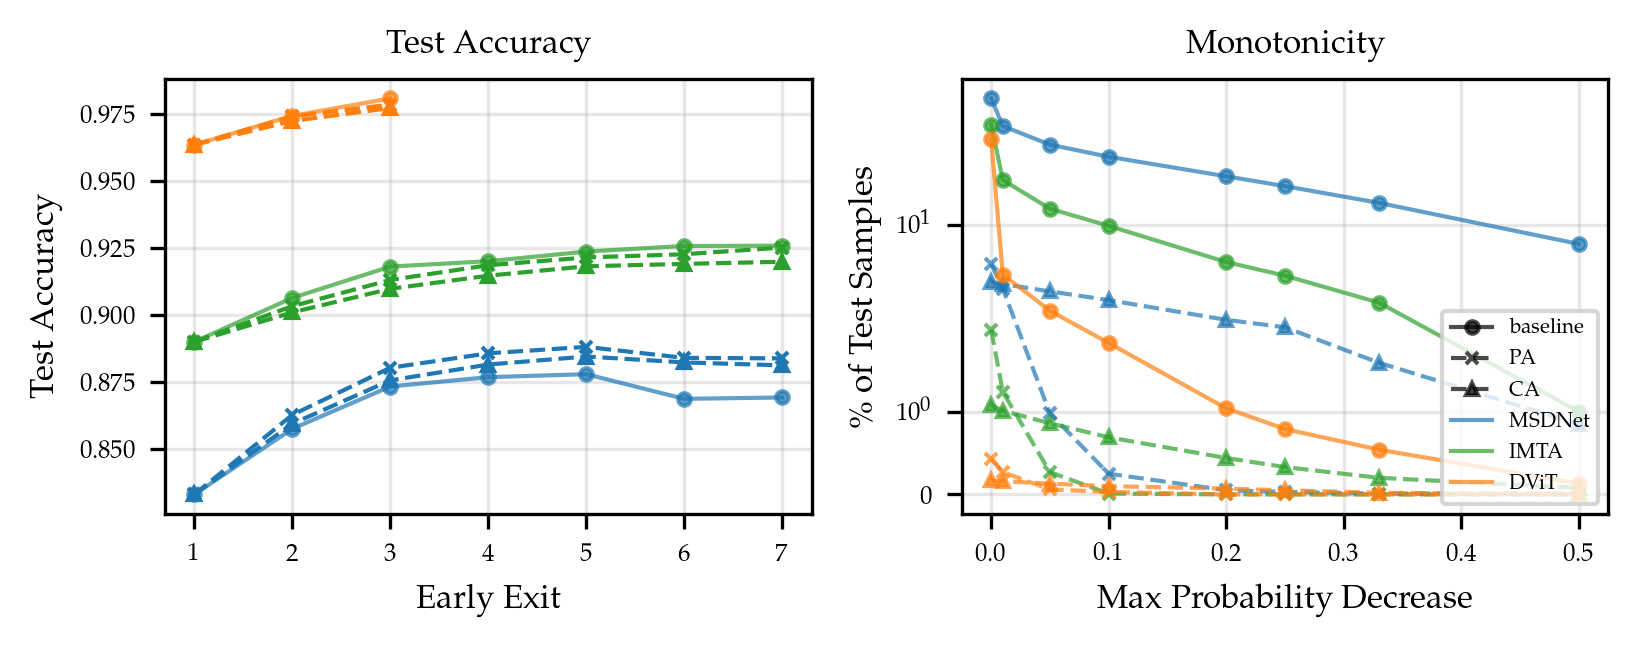

In [21]:
# sns.set_theme()
# FONT_SIZE = 11
# plt.rcParams.update({'font.size': FONT_SIZE})

fig, ax = plt.subplots(1, 2, figsize=(text_width, 0.4*text_width))

ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet"]) + 1)), CIFAR_10_DICT["MSDNet"], label='MSDNet', marker='o', color=COLOR_DICT["MSDNet"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-PA"]) + 1)), CIFAR_10_DICT["MSDNet-PA"], label='MSDNet-PA', marker='x', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["MSDNet-CA"]) + 1)), CIFAR_10_DICT["MSDNet-CA"], label='MSDNet-CA', marker='^', color=COLOR_DICT["MSDNet"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA"]) + 1)), CIFAR_10_DICT["IMTA"], label='IMTA', marker='o', color=COLOR_DICT["IMTA"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-PA"]) + 1)), CIFAR_10_DICT["IMTA-PA"], label='IMTA-PA', marker='x', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["IMTA-CA"]) + 1)), CIFAR_10_DICT["IMTA-CA"], label='IMTA-CA', marker='^', color=COLOR_DICT["IMTA"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT"]) + 1)), CIFAR_10_DICT["DViT"], label='DViT', marker='o', color=COLOR_DICT["DViT"], alpha=0.7)
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-PA"]) + 1)), CIFAR_10_DICT["DViT-PA"], label='DViT-PA', marker='x', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].plot(list(range(1, len(CIFAR_10_DICT["DViT-CA"]) + 1)), CIFAR_10_DICT["DViT-CA"], label='DViT-CA', marker='^', color=COLOR_DICT["DViT"], linestyle='--')
ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_title('Test Accuracy')
ax[0].set_xticks([x for x in range(1, 8)])
# ax[0].legend()

for name, percentages in CIFAR_10_DICT_MONO.items():
    ax[1].plot(THRESHOLDS, percentages, marker=marker_styles[name], label=name, color=colors[name], ls=line_styles[name], alpha=0.7)

ax[1].set_xlabel('Max Probability Decrease')
ax[1].set_ylabel('\% of Test Samples')
# ax[0].legend()
# set log scale
ax[1].set_yscale('symlog')
ax[1].set_title('Monotonicity')

# construct a legend with different line styles
lines = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.7),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='^', alpha=0.7),
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.7),
]
labels = ['baseline', 'PA', 'CA', 'MSDNet', 'IMTA', 'DViT']
ax[1].legend(lines, labels, loc='lower right', fontsize=5)


plt.tight_layout()
plt.savefig(f'figures/figure_cifar_10_results_appendix.pdf', bbox_inches='tight')
plt.show()